So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(14, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(17, device='cuda:0')
tensor(16, device='cuda:0')


add noiise

In [7]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[ 0.0013,  0.0135,  0.0054,  ..., -0.0047,  0.0033, -0.0097],
        [ 0.0080, -0.0057,  0.0010,  ...,  0.0009, -0.0134,  0.0105],
        [-0.0103, -0.0029,  0.0185,  ..., -0.0133, -0.0037,  0.0134],
        ...,
        [ 0.0073, -0.0149, -0.0108,  ..., -0.0047, -0.0137,  0.0070],
        [ 0.0006, -0.0141, -0.0124,  ..., -0.0085,  0.0069, -0.0110],
        [-0.0159,  0.0177, -0.0087,  ..., -0.0076, -0.0009,  0.0078]],
       device='cuda:0')

In [8]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [9]:
actual_data.shape

torch.Size([10000, 60])

In [10]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [11]:
global_t = 4

Example of what worked before

In [12]:
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.025238
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.364944
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.814362
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.379112
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.789692
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.276009
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.740120
====> Epoch: 1 Average loss: 40.2651
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.672668
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.857777
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.326408
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.102455
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.597836
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.990261
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.360985
====> Epoch: 2 Average loss: 36.4155
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.524200
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.207508
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.857361
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.793507
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.989220
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.002998
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.257687
====> Epoch: 22 Average loss: 31.2449
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.386927
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.034521
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.336792
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.313383
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.017269
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.128880
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.526924
====> Epoch: 23 Average loss: 31.1897
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.333666
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.354042
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.074629
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.058277
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.226425
Train Epoch: 24 [6400/8000 (80%)]	Loss: 30.920198
Train Epoch: 24 [7680/8000 (96%)]	Loss: 30.927282
====> Epoch: 24 Average loss: 31.1282
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.069897
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.13264

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.636246
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.380066
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.260462
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.643415
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.413063
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.506575
====> Epoch: 44 Average loss: 30.4689
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.496719
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.805012
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.479860
Train Epoch: 45 [3840/8000 (48%)]	Loss: 29.870306
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.277435
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.269686
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.485321
====> Epoch: 45 Average loss: 30.4502
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.353239
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.411106
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.417006
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.377390
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.554312
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.261757
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.214964
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.428467
====> Epoch: 65 Average loss: 30.2000
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.205038
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.331818
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.319281
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.250435
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.162100
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.575787
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.229120
====> Epoch: 66 Average loss: 30.1954
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.468554
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.096970
Train Epoch: 67 [2560/8000 (32%)]	Loss: 29.976551
Train Epoch: 67 [3840/8000 (48%)]	Loss: 29.963739
Train Epoch: 67 [5120/8000 (64%)]	Loss: 29.879070
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.164143
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.291126
====> Epoch: 67 Average loss: 30.1869
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.12374

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.097862
Train Epoch: 87 [2560/8000 (32%)]	Loss: 29.968924
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.154158
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.106409
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.150116
Train Epoch: 87 [7680/8000 (96%)]	Loss: 29.816467
====> Epoch: 87 Average loss: 30.0200
Train Epoch: 88 [0/8000 (0%)]	Loss: 29.852245
Train Epoch: 88 [1280/8000 (16%)]	Loss: 29.997995
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.010605
Train Epoch: 88 [3840/8000 (48%)]	Loss: 29.869608
Train Epoch: 88 [5120/8000 (64%)]	Loss: 29.999699
Train Epoch: 88 [6400/8000 (80%)]	Loss: 29.869789
Train Epoch: 88 [7680/8000 (96%)]	Loss: 29.824991
====> Epoch: 88 Average loss: 30.0172
Train Epoch: 89 [0/8000 (0%)]	Loss: 29.926689
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.235100
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.369614
Train Epoch: 89 [3840/8000 (48%)]	Loss: 29.906677
Train Epoch: 89 [5120/8000 (64%)]	Loss: 29.949619
Train Epoch: 89 [6400/8000 (80%)

Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.111988
Train Epoch: 108 [5120/8000 (64%)]	Loss: 29.967243
Train Epoch: 108 [6400/8000 (80%)]	Loss: 29.746244
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.104080
====> Epoch: 108 Average loss: 29.9219
Train Epoch: 109 [0/8000 (0%)]	Loss: 29.962467
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.001184
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.052572
Train Epoch: 109 [3840/8000 (48%)]	Loss: 29.810211
Train Epoch: 109 [5120/8000 (64%)]	Loss: 29.958689
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.108978
Train Epoch: 109 [7680/8000 (96%)]	Loss: 29.713139
====> Epoch: 109 Average loss: 29.9106
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.066280
Train Epoch: 110 [1280/8000 (16%)]	Loss: 29.868971
Train Epoch: 110 [2560/8000 (32%)]	Loss: 29.816673
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.107143
Train Epoch: 110 [5120/8000 (64%)]	Loss: 29.900051
Train Epoch: 110 [6400/8000 (80%)]	Loss: 30.089832
Train Epoch: 110 [7680/8000 (96%)]	Loss: 29.938700
====> Epoch:

Train Epoch: 129 [3840/8000 (48%)]	Loss: 29.881001
Train Epoch: 129 [5120/8000 (64%)]	Loss: 29.819818
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.101986
Train Epoch: 129 [7680/8000 (96%)]	Loss: 29.729719
====> Epoch: 129 Average loss: 29.8715
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.021824
Train Epoch: 130 [1280/8000 (16%)]	Loss: 30.123554
Train Epoch: 130 [2560/8000 (32%)]	Loss: 29.801779
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.012585
Train Epoch: 130 [5120/8000 (64%)]	Loss: 30.269943
Train Epoch: 130 [6400/8000 (80%)]	Loss: 29.789417
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.012442
====> Epoch: 130 Average loss: 29.8695
Train Epoch: 131 [0/8000 (0%)]	Loss: 29.933905
Train Epoch: 131 [1280/8000 (16%)]	Loss: 29.873446
Train Epoch: 131 [2560/8000 (32%)]	Loss: 29.807938
Train Epoch: 131 [3840/8000 (48%)]	Loss: 29.885004
Train Epoch: 131 [5120/8000 (64%)]	Loss: 29.556086
Train Epoch: 131 [6400/8000 (80%)]	Loss: 29.942333
Train Epoch: 131 [7680/8000 (96%)]	Loss: 30.014631
====> Epoch:

Train Epoch: 150 [3840/8000 (48%)]	Loss: 29.635920
Train Epoch: 150 [5120/8000 (64%)]	Loss: 29.854179
Train Epoch: 150 [6400/8000 (80%)]	Loss: 29.923254
Train Epoch: 150 [7680/8000 (96%)]	Loss: 29.756056
====> Epoch: 150 Average loss: 29.8447
Train Epoch: 151 [0/8000 (0%)]	Loss: 29.892080
Train Epoch: 151 [1280/8000 (16%)]	Loss: 29.775129
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.039793
Train Epoch: 151 [3840/8000 (48%)]	Loss: 29.996382
Train Epoch: 151 [5120/8000 (64%)]	Loss: 29.645355
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.122829
Train Epoch: 151 [7680/8000 (96%)]	Loss: 29.612366
====> Epoch: 151 Average loss: 29.8476
Train Epoch: 152 [0/8000 (0%)]	Loss: 29.872206
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.007320
Train Epoch: 152 [2560/8000 (32%)]	Loss: 29.966110
Train Epoch: 152 [3840/8000 (48%)]	Loss: 29.747076
Train Epoch: 152 [5120/8000 (64%)]	Loss: 29.732082
Train Epoch: 152 [6400/8000 (80%)]	Loss: 29.661459
Train Epoch: 152 [7680/8000 (96%)]	Loss: 29.898163
====> Epoch:

Train Epoch: 171 [3840/8000 (48%)]	Loss: 29.691778
Train Epoch: 171 [5120/8000 (64%)]	Loss: 29.820354
Train Epoch: 171 [6400/8000 (80%)]	Loss: 29.697687
Train Epoch: 171 [7680/8000 (96%)]	Loss: 29.529900
====> Epoch: 171 Average loss: 29.8322
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.050375
Train Epoch: 172 [1280/8000 (16%)]	Loss: 29.819826
Train Epoch: 172 [2560/8000 (32%)]	Loss: 29.893105
Train Epoch: 172 [3840/8000 (48%)]	Loss: 29.835381
Train Epoch: 172 [5120/8000 (64%)]	Loss: 29.854538
Train Epoch: 172 [6400/8000 (80%)]	Loss: 29.700729
Train Epoch: 172 [7680/8000 (96%)]	Loss: 29.893032
====> Epoch: 172 Average loss: 29.8292
Train Epoch: 173 [0/8000 (0%)]	Loss: 29.822430
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.048073
Train Epoch: 173 [2560/8000 (32%)]	Loss: 29.792807
Train Epoch: 173 [3840/8000 (48%)]	Loss: 29.933641
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.016602
Train Epoch: 173 [6400/8000 (80%)]	Loss: 29.747728
Train Epoch: 173 [7680/8000 (96%)]	Loss: 29.592339
====> Epoch:

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.103653
Train Epoch: 192 [5120/8000 (64%)]	Loss: 29.973534
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.001276
Train Epoch: 192 [7680/8000 (96%)]	Loss: 29.812340
====> Epoch: 192 Average loss: 29.8118
Train Epoch: 193 [0/8000 (0%)]	Loss: 29.887241
Train Epoch: 193 [1280/8000 (16%)]	Loss: 29.800154
Train Epoch: 193 [2560/8000 (32%)]	Loss: 29.862894
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.167154
Train Epoch: 193 [5120/8000 (64%)]	Loss: 29.892557
Train Epoch: 193 [6400/8000 (80%)]	Loss: 29.848461
Train Epoch: 193 [7680/8000 (96%)]	Loss: 29.772787
====> Epoch: 193 Average loss: 29.8129
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.023052
Train Epoch: 194 [1280/8000 (16%)]	Loss: 29.723381
Train Epoch: 194 [2560/8000 (32%)]	Loss: 29.811617
Train Epoch: 194 [3840/8000 (48%)]	Loss: 29.659929
Train Epoch: 194 [5120/8000 (64%)]	Loss: 29.900434
Train Epoch: 194 [6400/8000 (80%)]	Loss: 29.959351
Train Epoch: 194 [7680/8000 (96%)]	Loss: 30.050060
====> Epoch:

Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.016869
Train Epoch: 213 [5120/8000 (64%)]	Loss: 29.846630
Train Epoch: 213 [6400/8000 (80%)]	Loss: 29.708797
Train Epoch: 213 [7680/8000 (96%)]	Loss: 29.815838
====> Epoch: 213 Average loss: 29.8011
Train Epoch: 214 [0/8000 (0%)]	Loss: 29.759727
Train Epoch: 214 [1280/8000 (16%)]	Loss: 29.817102
Train Epoch: 214 [2560/8000 (32%)]	Loss: 29.760227
Train Epoch: 214 [3840/8000 (48%)]	Loss: 29.571650
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.152962
Train Epoch: 214 [6400/8000 (80%)]	Loss: 29.853821
Train Epoch: 214 [7680/8000 (96%)]	Loss: 29.901327
====> Epoch: 214 Average loss: 29.8008
Train Epoch: 215 [0/8000 (0%)]	Loss: 29.709595
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.049688
Train Epoch: 215 [2560/8000 (32%)]	Loss: 29.787767
Train Epoch: 215 [3840/8000 (48%)]	Loss: 29.884525
Train Epoch: 215 [5120/8000 (64%)]	Loss: 29.654650
Train Epoch: 215 [6400/8000 (80%)]	Loss: 30.027760
Train Epoch: 215 [7680/8000 (96%)]	Loss: 29.874723
====> Epoch:

Train Epoch: 234 [3840/8000 (48%)]	Loss: 29.908997
Train Epoch: 234 [5120/8000 (64%)]	Loss: 29.866787
Train Epoch: 234 [6400/8000 (80%)]	Loss: 29.827703
Train Epoch: 234 [7680/8000 (96%)]	Loss: 29.581121
====> Epoch: 234 Average loss: 29.7829
Train Epoch: 235 [0/8000 (0%)]	Loss: 29.701721
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.068953
Train Epoch: 235 [2560/8000 (32%)]	Loss: 29.704588
Train Epoch: 235 [3840/8000 (48%)]	Loss: 29.709436
Train Epoch: 235 [5120/8000 (64%)]	Loss: 29.659035
Train Epoch: 235 [6400/8000 (80%)]	Loss: 29.860847
Train Epoch: 235 [7680/8000 (96%)]	Loss: 29.674393
====> Epoch: 235 Average loss: 29.7795
Train Epoch: 236 [0/8000 (0%)]	Loss: 29.649414
Train Epoch: 236 [1280/8000 (16%)]	Loss: 29.797354
Train Epoch: 236 [2560/8000 (32%)]	Loss: 29.569967
Train Epoch: 236 [3840/8000 (48%)]	Loss: 29.799479
Train Epoch: 236 [5120/8000 (64%)]	Loss: 29.751755
Train Epoch: 236 [6400/8000 (80%)]	Loss: 29.808723
Train Epoch: 236 [7680/8000 (96%)]	Loss: 29.927212
====> Epoch:

Train Epoch: 255 [3840/8000 (48%)]	Loss: 29.793802
Train Epoch: 255 [5120/8000 (64%)]	Loss: 29.549372
Train Epoch: 255 [6400/8000 (80%)]	Loss: 29.958109
Train Epoch: 255 [7680/8000 (96%)]	Loss: 29.709211
====> Epoch: 255 Average loss: 29.7752
Train Epoch: 256 [0/8000 (0%)]	Loss: 29.888754
Train Epoch: 256 [1280/8000 (16%)]	Loss: 29.682058
Train Epoch: 256 [2560/8000 (32%)]	Loss: 29.733076
Train Epoch: 256 [3840/8000 (48%)]	Loss: 29.783556
Train Epoch: 256 [5120/8000 (64%)]	Loss: 29.608585
Train Epoch: 256 [6400/8000 (80%)]	Loss: 29.777040
Train Epoch: 256 [7680/8000 (96%)]	Loss: 29.753036
====> Epoch: 256 Average loss: 29.7678
Train Epoch: 257 [0/8000 (0%)]	Loss: 29.705544
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.064556
Train Epoch: 257 [2560/8000 (32%)]	Loss: 29.838211
Train Epoch: 257 [3840/8000 (48%)]	Loss: 29.625721
Train Epoch: 257 [5120/8000 (64%)]	Loss: 29.656437
Train Epoch: 257 [6400/8000 (80%)]	Loss: 29.929043
Train Epoch: 257 [7680/8000 (96%)]	Loss: 29.622179
====> Epoch:

Train Epoch: 276 [3840/8000 (48%)]	Loss: 29.527943
Train Epoch: 276 [5120/8000 (64%)]	Loss: 29.919231
Train Epoch: 276 [6400/8000 (80%)]	Loss: 29.883381
Train Epoch: 276 [7680/8000 (96%)]	Loss: 29.737637
====> Epoch: 276 Average loss: 29.7668
Train Epoch: 277 [0/8000 (0%)]	Loss: 29.881170
Train Epoch: 277 [1280/8000 (16%)]	Loss: 29.546762
Train Epoch: 277 [2560/8000 (32%)]	Loss: 29.769621
Train Epoch: 277 [3840/8000 (48%)]	Loss: 29.666191
Train Epoch: 277 [5120/8000 (64%)]	Loss: 29.841217
Train Epoch: 277 [6400/8000 (80%)]	Loss: 29.634481
Train Epoch: 277 [7680/8000 (96%)]	Loss: 29.966608
====> Epoch: 277 Average loss: 29.7637
Train Epoch: 278 [0/8000 (0%)]	Loss: 29.711842
Train Epoch: 278 [1280/8000 (16%)]	Loss: 29.920826
Train Epoch: 278 [2560/8000 (32%)]	Loss: 29.825642
Train Epoch: 278 [3840/8000 (48%)]	Loss: 29.752100
Train Epoch: 278 [5120/8000 (64%)]	Loss: 29.508493
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.009190
Train Epoch: 278 [7680/8000 (96%)]	Loss: 29.987354
====> Epoch:

Train Epoch: 297 [3840/8000 (48%)]	Loss: 29.483948
Train Epoch: 297 [5120/8000 (64%)]	Loss: 29.837488
Train Epoch: 297 [6400/8000 (80%)]	Loss: 29.732147
Train Epoch: 297 [7680/8000 (96%)]	Loss: 29.536112
====> Epoch: 297 Average loss: 29.7534
Train Epoch: 298 [0/8000 (0%)]	Loss: 29.900091
Train Epoch: 298 [1280/8000 (16%)]	Loss: 29.646999
Train Epoch: 298 [2560/8000 (32%)]	Loss: 29.766005
Train Epoch: 298 [3840/8000 (48%)]	Loss: 29.658384
Train Epoch: 298 [5120/8000 (64%)]	Loss: 29.680887
Train Epoch: 298 [6400/8000 (80%)]	Loss: 29.724232
Train Epoch: 298 [7680/8000 (96%)]	Loss: 29.788368
====> Epoch: 298 Average loss: 29.7636
Train Epoch: 299 [0/8000 (0%)]	Loss: 29.664936
Train Epoch: 299 [1280/8000 (16%)]	Loss: 29.873949
Train Epoch: 299 [2560/8000 (32%)]	Loss: 29.949856
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.011860
Train Epoch: 299 [5120/8000 (64%)]	Loss: 29.540829
Train Epoch: 299 [6400/8000 (80%)]	Loss: 29.599043
Train Epoch: 299 [7680/8000 (96%)]	Loss: 29.694389
====> Epoch:

Train Epoch: 318 [3840/8000 (48%)]	Loss: 29.585146
Train Epoch: 318 [5120/8000 (64%)]	Loss: 29.873222
Train Epoch: 318 [6400/8000 (80%)]	Loss: 29.822659
Train Epoch: 318 [7680/8000 (96%)]	Loss: 29.443905
====> Epoch: 318 Average loss: 29.7418
Train Epoch: 319 [0/8000 (0%)]	Loss: 29.548079
Train Epoch: 319 [1280/8000 (16%)]	Loss: 29.644941
Train Epoch: 319 [2560/8000 (32%)]	Loss: 29.703939
Train Epoch: 319 [3840/8000 (48%)]	Loss: 29.686186
Train Epoch: 319 [5120/8000 (64%)]	Loss: 29.728346
Train Epoch: 319 [6400/8000 (80%)]	Loss: 29.991512
Train Epoch: 319 [7680/8000 (96%)]	Loss: 29.965986
====> Epoch: 319 Average loss: 29.7438
Train Epoch: 320 [0/8000 (0%)]	Loss: 29.594917
Train Epoch: 320 [1280/8000 (16%)]	Loss: 29.814066
Train Epoch: 320 [2560/8000 (32%)]	Loss: 29.742224
Train Epoch: 320 [3840/8000 (48%)]	Loss: 29.478689
Train Epoch: 320 [5120/8000 (64%)]	Loss: 29.547209
Train Epoch: 320 [6400/8000 (80%)]	Loss: 29.879192
Train Epoch: 320 [7680/8000 (96%)]	Loss: 29.988377
====> Epoch:

Train Epoch: 339 [3840/8000 (48%)]	Loss: 29.548399
Train Epoch: 339 [5120/8000 (64%)]	Loss: 29.792904
Train Epoch: 339 [6400/8000 (80%)]	Loss: 29.612423
Train Epoch: 339 [7680/8000 (96%)]	Loss: 29.946529
====> Epoch: 339 Average loss: 29.7344
Train Epoch: 340 [0/8000 (0%)]	Loss: 29.776411
Train Epoch: 340 [1280/8000 (16%)]	Loss: 29.644857
Train Epoch: 340 [2560/8000 (32%)]	Loss: 29.623465
Train Epoch: 340 [3840/8000 (48%)]	Loss: 29.749525
Train Epoch: 340 [5120/8000 (64%)]	Loss: 29.746956
Train Epoch: 340 [6400/8000 (80%)]	Loss: 29.797812
Train Epoch: 340 [7680/8000 (96%)]	Loss: 29.639267
====> Epoch: 340 Average loss: 29.7320
Train Epoch: 341 [0/8000 (0%)]	Loss: 29.826471
Train Epoch: 341 [1280/8000 (16%)]	Loss: 29.692921
Train Epoch: 341 [2560/8000 (32%)]	Loss: 29.844282
Train Epoch: 341 [3840/8000 (48%)]	Loss: 29.922817
Train Epoch: 341 [5120/8000 (64%)]	Loss: 29.650442
Train Epoch: 341 [6400/8000 (80%)]	Loss: 29.670443
Train Epoch: 341 [7680/8000 (96%)]	Loss: 29.811575
====> Epoch:

Train Epoch: 360 [3840/8000 (48%)]	Loss: 29.826050
Train Epoch: 360 [5120/8000 (64%)]	Loss: 29.845442
Train Epoch: 360 [6400/8000 (80%)]	Loss: 29.907892
Train Epoch: 360 [7680/8000 (96%)]	Loss: 29.536388
====> Epoch: 360 Average loss: 29.7292
Train Epoch: 361 [0/8000 (0%)]	Loss: 29.954815
Train Epoch: 361 [1280/8000 (16%)]	Loss: 29.737612
Train Epoch: 361 [2560/8000 (32%)]	Loss: 29.345512
Train Epoch: 361 [3840/8000 (48%)]	Loss: 29.608006
Train Epoch: 361 [5120/8000 (64%)]	Loss: 29.728193
Train Epoch: 361 [6400/8000 (80%)]	Loss: 29.474813
Train Epoch: 361 [7680/8000 (96%)]	Loss: 29.783216
====> Epoch: 361 Average loss: 29.7247
Train Epoch: 362 [0/8000 (0%)]	Loss: 29.871235
Train Epoch: 362 [1280/8000 (16%)]	Loss: 29.808031
Train Epoch: 362 [2560/8000 (32%)]	Loss: 29.715378
Train Epoch: 362 [3840/8000 (48%)]	Loss: 29.757471
Train Epoch: 362 [5120/8000 (64%)]	Loss: 29.461494
Train Epoch: 362 [6400/8000 (80%)]	Loss: 29.827595
Train Epoch: 362 [7680/8000 (96%)]	Loss: 29.830832
====> Epoch:

Train Epoch: 381 [3840/8000 (48%)]	Loss: 29.887499
Train Epoch: 381 [5120/8000 (64%)]	Loss: 29.525244
Train Epoch: 381 [6400/8000 (80%)]	Loss: 29.842644
Train Epoch: 381 [7680/8000 (96%)]	Loss: 29.541941
====> Epoch: 381 Average loss: 29.7201
Train Epoch: 382 [0/8000 (0%)]	Loss: 29.779127
Train Epoch: 382 [1280/8000 (16%)]	Loss: 29.766912
Train Epoch: 382 [2560/8000 (32%)]	Loss: 29.576981
Train Epoch: 382 [3840/8000 (48%)]	Loss: 29.815374
Train Epoch: 382 [5120/8000 (64%)]	Loss: 29.548367
Train Epoch: 382 [6400/8000 (80%)]	Loss: 29.656792
Train Epoch: 382 [7680/8000 (96%)]	Loss: 29.683804
====> Epoch: 382 Average loss: 29.7205
Train Epoch: 383 [0/8000 (0%)]	Loss: 29.694931
Train Epoch: 383 [1280/8000 (16%)]	Loss: 29.598644
Train Epoch: 383 [2560/8000 (32%)]	Loss: 29.900866
Train Epoch: 383 [3840/8000 (48%)]	Loss: 29.752909
Train Epoch: 383 [5120/8000 (64%)]	Loss: 29.608877
Train Epoch: 383 [6400/8000 (80%)]	Loss: 29.857540
Train Epoch: 383 [7680/8000 (96%)]	Loss: 29.636829
====> Epoch:

Train Epoch: 402 [3840/8000 (48%)]	Loss: 29.972483
Train Epoch: 402 [5120/8000 (64%)]	Loss: 29.886158
Train Epoch: 402 [6400/8000 (80%)]	Loss: 29.915936
Train Epoch: 402 [7680/8000 (96%)]	Loss: 30.083668
====> Epoch: 402 Average loss: 29.7167
Train Epoch: 403 [0/8000 (0%)]	Loss: 29.413553
Train Epoch: 403 [1280/8000 (16%)]	Loss: 29.540613
Train Epoch: 403 [2560/8000 (32%)]	Loss: 29.931137
Train Epoch: 403 [3840/8000 (48%)]	Loss: 29.446997
Train Epoch: 403 [5120/8000 (64%)]	Loss: 29.951281
Train Epoch: 403 [6400/8000 (80%)]	Loss: 29.717253
Train Epoch: 403 [7680/8000 (96%)]	Loss: 29.696468
====> Epoch: 403 Average loss: 29.7093
Train Epoch: 404 [0/8000 (0%)]	Loss: 29.893000
Train Epoch: 404 [1280/8000 (16%)]	Loss: 29.636406
Train Epoch: 404 [2560/8000 (32%)]	Loss: 29.685219
Train Epoch: 404 [3840/8000 (48%)]	Loss: 29.755812
Train Epoch: 404 [5120/8000 (64%)]	Loss: 29.842770
Train Epoch: 404 [6400/8000 (80%)]	Loss: 29.577820
Train Epoch: 404 [7680/8000 (96%)]	Loss: 29.754572
====> Epoch:

Train Epoch: 423 [3840/8000 (48%)]	Loss: 29.644356
Train Epoch: 423 [5120/8000 (64%)]	Loss: 29.587803
Train Epoch: 423 [6400/8000 (80%)]	Loss: 29.663441
Train Epoch: 423 [7680/8000 (96%)]	Loss: 29.511778
====> Epoch: 423 Average loss: 29.7076
Train Epoch: 424 [0/8000 (0%)]	Loss: 29.960463
Train Epoch: 424 [1280/8000 (16%)]	Loss: 29.953264
Train Epoch: 424 [2560/8000 (32%)]	Loss: 29.748463
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.010864
Train Epoch: 424 [5120/8000 (64%)]	Loss: 29.933643
Train Epoch: 424 [6400/8000 (80%)]	Loss: 29.607874
Train Epoch: 424 [7680/8000 (96%)]	Loss: 29.511568
====> Epoch: 424 Average loss: 29.7075
Train Epoch: 425 [0/8000 (0%)]	Loss: 29.954382
Train Epoch: 425 [1280/8000 (16%)]	Loss: 29.730968
Train Epoch: 425 [2560/8000 (32%)]	Loss: 29.751513
Train Epoch: 425 [3840/8000 (48%)]	Loss: 29.814991
Train Epoch: 425 [5120/8000 (64%)]	Loss: 29.662445
Train Epoch: 425 [6400/8000 (80%)]	Loss: 29.790813
Train Epoch: 425 [7680/8000 (96%)]	Loss: 29.646811
====> Epoch:

Train Epoch: 444 [3840/8000 (48%)]	Loss: 29.614618
Train Epoch: 444 [5120/8000 (64%)]	Loss: 29.843550
Train Epoch: 444 [6400/8000 (80%)]	Loss: 29.854256
Train Epoch: 444 [7680/8000 (96%)]	Loss: 29.609081
====> Epoch: 444 Average loss: 29.7060
Train Epoch: 445 [0/8000 (0%)]	Loss: 29.842545
Train Epoch: 445 [1280/8000 (16%)]	Loss: 29.714478
Train Epoch: 445 [2560/8000 (32%)]	Loss: 29.583290
Train Epoch: 445 [3840/8000 (48%)]	Loss: 29.638494
Train Epoch: 445 [5120/8000 (64%)]	Loss: 29.449972
Train Epoch: 445 [6400/8000 (80%)]	Loss: 29.767483
Train Epoch: 445 [7680/8000 (96%)]	Loss: 29.782160
====> Epoch: 445 Average loss: 29.7023
Train Epoch: 446 [0/8000 (0%)]	Loss: 29.669333
Train Epoch: 446 [1280/8000 (16%)]	Loss: 29.801332
Train Epoch: 446 [2560/8000 (32%)]	Loss: 29.840090
Train Epoch: 446 [3840/8000 (48%)]	Loss: 29.612436
Train Epoch: 446 [5120/8000 (64%)]	Loss: 29.751421
Train Epoch: 446 [6400/8000 (80%)]	Loss: 29.570148
Train Epoch: 446 [7680/8000 (96%)]	Loss: 29.913000
====> Epoch:

Train Epoch: 465 [3840/8000 (48%)]	Loss: 29.795454
Train Epoch: 465 [5120/8000 (64%)]	Loss: 29.874350
Train Epoch: 465 [6400/8000 (80%)]	Loss: 29.676275
Train Epoch: 465 [7680/8000 (96%)]	Loss: 29.618580
====> Epoch: 465 Average loss: 29.6980
Train Epoch: 466 [0/8000 (0%)]	Loss: 29.923510
Train Epoch: 466 [1280/8000 (16%)]	Loss: 29.560101
Train Epoch: 466 [2560/8000 (32%)]	Loss: 29.346855
Train Epoch: 466 [3840/8000 (48%)]	Loss: 29.966204
Train Epoch: 466 [5120/8000 (64%)]	Loss: 29.648634
Train Epoch: 466 [6400/8000 (80%)]	Loss: 29.566189
Train Epoch: 466 [7680/8000 (96%)]	Loss: 29.746029
====> Epoch: 466 Average loss: 29.6971
Train Epoch: 467 [0/8000 (0%)]	Loss: 29.632994
Train Epoch: 467 [1280/8000 (16%)]	Loss: 29.992785
Train Epoch: 467 [2560/8000 (32%)]	Loss: 29.785627
Train Epoch: 467 [3840/8000 (48%)]	Loss: 29.836670
Train Epoch: 467 [5120/8000 (64%)]	Loss: 29.602131
Train Epoch: 467 [6400/8000 (80%)]	Loss: 29.267851
Train Epoch: 467 [7680/8000 (96%)]	Loss: 29.390198
====> Epoch:

Train Epoch: 486 [3840/8000 (48%)]	Loss: 29.765944
Train Epoch: 486 [5120/8000 (64%)]	Loss: 29.843380
Train Epoch: 486 [6400/8000 (80%)]	Loss: 29.807360
Train Epoch: 486 [7680/8000 (96%)]	Loss: 29.654209
====> Epoch: 486 Average loss: 29.6915
Train Epoch: 487 [0/8000 (0%)]	Loss: 29.642105
Train Epoch: 487 [1280/8000 (16%)]	Loss: 29.721153
Train Epoch: 487 [2560/8000 (32%)]	Loss: 29.634399
Train Epoch: 487 [3840/8000 (48%)]	Loss: 29.524160
Train Epoch: 487 [5120/8000 (64%)]	Loss: 29.703186
Train Epoch: 487 [6400/8000 (80%)]	Loss: 29.444208
Train Epoch: 487 [7680/8000 (96%)]	Loss: 29.711212
====> Epoch: 487 Average loss: 29.6931
Train Epoch: 488 [0/8000 (0%)]	Loss: 29.413984
Train Epoch: 488 [1280/8000 (16%)]	Loss: 29.590284
Train Epoch: 488 [2560/8000 (32%)]	Loss: 29.612022
Train Epoch: 488 [3840/8000 (48%)]	Loss: 29.807470
Train Epoch: 488 [5120/8000 (64%)]	Loss: 29.456078
Train Epoch: 488 [6400/8000 (80%)]	Loss: 29.747131
Train Epoch: 488 [7680/8000 (96%)]	Loss: 29.561817
====> Epoch:

Train Epoch: 507 [3840/8000 (48%)]	Loss: 29.477955
Train Epoch: 507 [5120/8000 (64%)]	Loss: 29.510893
Train Epoch: 507 [6400/8000 (80%)]	Loss: 29.507200
Train Epoch: 507 [7680/8000 (96%)]	Loss: 29.823786
====> Epoch: 507 Average loss: 29.6840
Train Epoch: 508 [0/8000 (0%)]	Loss: 29.633787
Train Epoch: 508 [1280/8000 (16%)]	Loss: 29.781296
Train Epoch: 508 [2560/8000 (32%)]	Loss: 29.530794
Train Epoch: 508 [3840/8000 (48%)]	Loss: 29.652380
Train Epoch: 508 [5120/8000 (64%)]	Loss: 29.721819
Train Epoch: 508 [6400/8000 (80%)]	Loss: 29.815012
Train Epoch: 508 [7680/8000 (96%)]	Loss: 29.689747
====> Epoch: 508 Average loss: 29.6896
Train Epoch: 509 [0/8000 (0%)]	Loss: 29.615316
Train Epoch: 509 [1280/8000 (16%)]	Loss: 29.727814
Train Epoch: 509 [2560/8000 (32%)]	Loss: 29.849977
Train Epoch: 509 [3840/8000 (48%)]	Loss: 29.373297
Train Epoch: 509 [5120/8000 (64%)]	Loss: 29.676727
Train Epoch: 509 [6400/8000 (80%)]	Loss: 29.775665
Train Epoch: 509 [7680/8000 (96%)]	Loss: 29.716639
====> Epoch:

Train Epoch: 528 [3840/8000 (48%)]	Loss: 29.875984
Train Epoch: 528 [5120/8000 (64%)]	Loss: 29.316631
Train Epoch: 528 [6400/8000 (80%)]	Loss: 29.540741
Train Epoch: 528 [7680/8000 (96%)]	Loss: 29.648657
====> Epoch: 528 Average loss: 29.6802
Train Epoch: 529 [0/8000 (0%)]	Loss: 29.379669
Train Epoch: 529 [1280/8000 (16%)]	Loss: 29.712761
Train Epoch: 529 [2560/8000 (32%)]	Loss: 29.598803
Train Epoch: 529 [3840/8000 (48%)]	Loss: 29.675518
Train Epoch: 529 [5120/8000 (64%)]	Loss: 29.471125
Train Epoch: 529 [6400/8000 (80%)]	Loss: 29.781223
Train Epoch: 529 [7680/8000 (96%)]	Loss: 29.606256
====> Epoch: 529 Average loss: 29.6867
Train Epoch: 530 [0/8000 (0%)]	Loss: 29.659550
Train Epoch: 530 [1280/8000 (16%)]	Loss: 29.619297
Train Epoch: 530 [2560/8000 (32%)]	Loss: 29.847219
Train Epoch: 530 [3840/8000 (48%)]	Loss: 29.469263
Train Epoch: 530 [5120/8000 (64%)]	Loss: 29.542496
Train Epoch: 530 [6400/8000 (80%)]	Loss: 29.708994
Train Epoch: 530 [7680/8000 (96%)]	Loss: 29.727295
====> Epoch:

Train Epoch: 549 [3840/8000 (48%)]	Loss: 29.853695
Train Epoch: 549 [5120/8000 (64%)]	Loss: 29.737402
Train Epoch: 549 [6400/8000 (80%)]	Loss: 29.680611
Train Epoch: 549 [7680/8000 (96%)]	Loss: 29.766066
====> Epoch: 549 Average loss: 29.6839
Train Epoch: 550 [0/8000 (0%)]	Loss: 29.590414
Train Epoch: 550 [1280/8000 (16%)]	Loss: 29.735992
Train Epoch: 550 [2560/8000 (32%)]	Loss: 29.696928
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.669851
Train Epoch: 550 [5120/8000 (64%)]	Loss: 29.802036
Train Epoch: 550 [6400/8000 (80%)]	Loss: 29.628387
Train Epoch: 550 [7680/8000 (96%)]	Loss: 29.645639
====> Epoch: 550 Average loss: 29.6819
Train Epoch: 551 [0/8000 (0%)]	Loss: 29.607632
Train Epoch: 551 [1280/8000 (16%)]	Loss: 29.720432
Train Epoch: 551 [2560/8000 (32%)]	Loss: 29.479298
Train Epoch: 551 [3840/8000 (48%)]	Loss: 29.599407
Train Epoch: 551 [5120/8000 (64%)]	Loss: 29.767609
Train Epoch: 551 [6400/8000 (80%)]	Loss: 29.702709
Train Epoch: 551 [7680/8000 (96%)]	Loss: 29.720011
====> Epoch:

Train Epoch: 570 [3840/8000 (48%)]	Loss: 29.681318
Train Epoch: 570 [5120/8000 (64%)]	Loss: 29.803434
Train Epoch: 570 [6400/8000 (80%)]	Loss: 29.448997
Train Epoch: 570 [7680/8000 (96%)]	Loss: 29.826357
====> Epoch: 570 Average loss: 29.6738
Train Epoch: 571 [0/8000 (0%)]	Loss: 29.862303
Train Epoch: 571 [1280/8000 (16%)]	Loss: 29.858595
Train Epoch: 571 [2560/8000 (32%)]	Loss: 29.802629
Train Epoch: 571 [3840/8000 (48%)]	Loss: 29.616951
Train Epoch: 571 [5120/8000 (64%)]	Loss: 29.531746
Train Epoch: 571 [6400/8000 (80%)]	Loss: 29.858206
Train Epoch: 571 [7680/8000 (96%)]	Loss: 29.476732
====> Epoch: 571 Average loss: 29.6764
Train Epoch: 572 [0/8000 (0%)]	Loss: 29.750761
Train Epoch: 572 [1280/8000 (16%)]	Loss: 29.514519
Train Epoch: 572 [2560/8000 (32%)]	Loss: 29.545895
Train Epoch: 572 [3840/8000 (48%)]	Loss: 29.888840
Train Epoch: 572 [5120/8000 (64%)]	Loss: 29.743465
Train Epoch: 572 [6400/8000 (80%)]	Loss: 29.672022
Train Epoch: 572 [7680/8000 (96%)]	Loss: 29.697639
====> Epoch:

Train Epoch: 591 [3840/8000 (48%)]	Loss: 29.567543
Train Epoch: 591 [5120/8000 (64%)]	Loss: 29.666666
Train Epoch: 591 [6400/8000 (80%)]	Loss: 29.724739
Train Epoch: 591 [7680/8000 (96%)]	Loss: 29.897310
====> Epoch: 591 Average loss: 29.6736
Train Epoch: 592 [0/8000 (0%)]	Loss: 29.715351
Train Epoch: 592 [1280/8000 (16%)]	Loss: 29.853861
Train Epoch: 592 [2560/8000 (32%)]	Loss: 29.726896
Train Epoch: 592 [3840/8000 (48%)]	Loss: 29.706593
Train Epoch: 592 [5120/8000 (64%)]	Loss: 29.725344
Train Epoch: 592 [6400/8000 (80%)]	Loss: 29.519926
Train Epoch: 592 [7680/8000 (96%)]	Loss: 29.852829
====> Epoch: 592 Average loss: 29.6713
Train Epoch: 593 [0/8000 (0%)]	Loss: 29.756287
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.554470
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.619387
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.726164
Train Epoch: 593 [5120/8000 (64%)]	Loss: 29.879265
Train Epoch: 593 [6400/8000 (80%)]	Loss: 29.727911
Train Epoch: 593 [7680/8000 (96%)]	Loss: 29.734886
====> Epoch:

tensor(47210564., device='cuda:0')
tensor(1627014.5000, device='cuda:0')


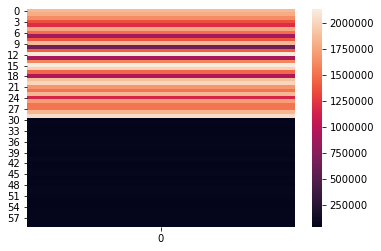

In [14]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(13723064., device='cuda:0')
tensor(403099.0938, device='cuda:0')


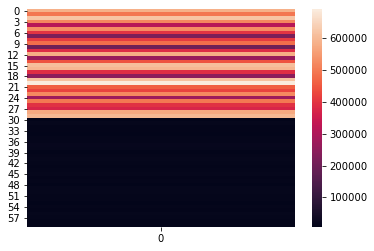

In [15]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(639052.3125, device='cuda:0')
tensor(98227.6719, device='cuda:0')


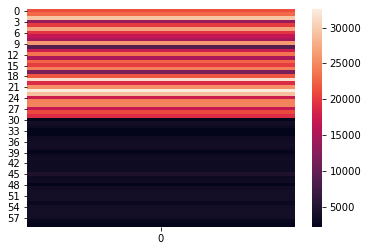

In [16]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(165813.9375, device='cuda:0')
tensor(18506.0684, device='cuda:0')


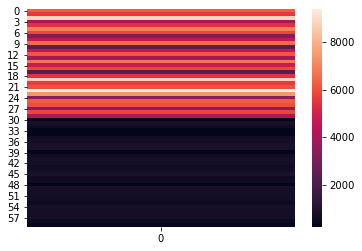

In [17]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(147307.8750, device='cuda:0')

**Write VAE_Gumbel_NInsta test here later**

The new model


In [19]:
vae_gumbel_truncated = VAE_Gumbel_NInstaState(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [20]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients_gumbel_state(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                          vae_gumbel_truncated.k, 
                                                          vae_gumbel_truncated.t).view(-1)
    if epoch == (n_epochs//5*4):
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1)

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.280743
Train Epoch: 1 [1280/8000 (16%)]	Loss: 40.614735
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.179207
Train Epoch: 1 [3840/8000 (48%)]	Loss: 39.611187
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.146030
Train Epoch: 1 [6400/8000 (80%)]	Loss: 38.659580
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.161747
====> Epoch: 1 Average loss: 39.6262
Train Epoch: 2 [0/8000 (0%)]	Loss: 37.915810
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.131409
Train Epoch: 2 [2560/8000 (32%)]	Loss: 36.806046
Train Epoch: 2 [3840/8000 (48%)]	Loss: 35.884571
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.540936
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.800106
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.571854
====> Epoch: 2 Average loss: 36.0916
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.510075
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.445385
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.872635
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.872471
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.483452
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.404030
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.417246
====> Epoch: 22 Average loss: 31.4198
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.343462
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.470804
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.439722
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.312643
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.469021
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.542503
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.223606
====> Epoch: 23 Average loss: 31.3072
Train Epoch: 24 [0/8000 (0%)]	Loss: 30.960484
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.680794
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.600447
Train Epoch: 24 [3840/8000 (48%)]	Loss: 30.862370
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.068138
Train Epoch: 24 [6400/8000 (80%)]	Loss: 31.450596
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.185123
====> Epoch: 24 Average loss: 31.2304
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.092773
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.33091

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.816082
Train Epoch: 44 [2560/8000 (32%)]	Loss: 31.057192
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.517794
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.788786
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.430391
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.488005
====> Epoch: 44 Average loss: 30.6760
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.815136
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.834820
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.163115
Train Epoch: 45 [3840/8000 (48%)]	Loss: 30.590200
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.747702
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.735264
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.309303
====> Epoch: 45 Average loss: 30.6723
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.700573
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.485542
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.611725
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.559538
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.807339
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.194992
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.567926
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.468134
====> Epoch: 65 Average loss: 30.4995
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.601236
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.452793
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.207905
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.386217
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.440447
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.590687
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.688759
====> Epoch: 66 Average loss: 30.4925
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.801802
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.362228
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.768410
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.308363
Train Epoch: 67 [5120/8000 (64%)]	Loss: 30.272717
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.281332
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.364555
====> Epoch: 67 Average loss: 30.4802
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.34153

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.206535
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.194124
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.612223
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.259312
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.049372
Train Epoch: 87 [7680/8000 (96%)]	Loss: 30.607521
====> Epoch: 87 Average loss: 30.3880
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.652987
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.368416
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.349449
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.581680
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.829262
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.360939
Train Epoch: 88 [7680/8000 (96%)]	Loss: 30.420294
====> Epoch: 88 Average loss: 30.3937
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.331537
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.647482
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.233006
Train Epoch: 89 [3840/8000 (48%)]	Loss: 30.308609
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.310215
Train Epoch: 89 [6400/8000 (80%)

Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.771437
Train Epoch: 108 [5120/8000 (64%)]	Loss: 30.347755
Train Epoch: 108 [6400/8000 (80%)]	Loss: 30.375172
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.150787
====> Epoch: 108 Average loss: 30.3606
Train Epoch: 109 [0/8000 (0%)]	Loss: 30.591547
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.048433
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.445433
Train Epoch: 109 [3840/8000 (48%)]	Loss: 30.175650
Train Epoch: 109 [5120/8000 (64%)]	Loss: 30.242785
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.994354
Train Epoch: 109 [7680/8000 (96%)]	Loss: 30.060064
====> Epoch: 109 Average loss: 30.3725
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.819498
Train Epoch: 110 [1280/8000 (16%)]	Loss: 30.716837
Train Epoch: 110 [2560/8000 (32%)]	Loss: 30.356461
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.025917
Train Epoch: 110 [5120/8000 (64%)]	Loss: 30.222900
Train Epoch: 110 [6400/8000 (80%)]	Loss: 29.948908
Train Epoch: 110 [7680/8000 (96%)]	Loss: 30.106127
====> Epoch:

Train Epoch: 129 [3840/8000 (48%)]	Loss: 30.337175
Train Epoch: 129 [5120/8000 (64%)]	Loss: 30.449577
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.221340
Train Epoch: 129 [7680/8000 (96%)]	Loss: 30.775145
====> Epoch: 129 Average loss: 30.3674
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.396839
Train Epoch: 130 [1280/8000 (16%)]	Loss: 29.957703
Train Epoch: 130 [2560/8000 (32%)]	Loss: 30.028477
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.190186
Train Epoch: 130 [5120/8000 (64%)]	Loss: 30.735262
Train Epoch: 130 [6400/8000 (80%)]	Loss: 30.572355
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.608938
====> Epoch: 130 Average loss: 30.3632
Train Epoch: 131 [0/8000 (0%)]	Loss: 30.068878
Train Epoch: 131 [1280/8000 (16%)]	Loss: 30.419701
Train Epoch: 131 [2560/8000 (32%)]	Loss: 30.186863
Train Epoch: 131 [3840/8000 (48%)]	Loss: 30.426302
Train Epoch: 131 [5120/8000 (64%)]	Loss: 30.856386
Train Epoch: 131 [6400/8000 (80%)]	Loss: 30.362345
Train Epoch: 131 [7680/8000 (96%)]	Loss: 29.929251
====> Epoch:

Train Epoch: 150 [3840/8000 (48%)]	Loss: 30.597755
Train Epoch: 150 [5120/8000 (64%)]	Loss: 30.579994
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.402700
Train Epoch: 150 [7680/8000 (96%)]	Loss: 30.148603
====> Epoch: 150 Average loss: 30.3709
Train Epoch: 151 [0/8000 (0%)]	Loss: 30.156727
Train Epoch: 151 [1280/8000 (16%)]	Loss: 30.391850
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.333134
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.373798
Train Epoch: 151 [5120/8000 (64%)]	Loss: 30.383308
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.531408
Train Epoch: 151 [7680/8000 (96%)]	Loss: 30.460066
====> Epoch: 151 Average loss: 30.3684
Train Epoch: 152 [0/8000 (0%)]	Loss: 30.352140
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.067081
Train Epoch: 152 [2560/8000 (32%)]	Loss: 29.998466
Train Epoch: 152 [3840/8000 (48%)]	Loss: 29.923729
Train Epoch: 152 [5120/8000 (64%)]	Loss: 30.345570
Train Epoch: 152 [6400/8000 (80%)]	Loss: 30.520502
Train Epoch: 152 [7680/8000 (96%)]	Loss: 30.446808
====> Epoch:

Train Epoch: 171 [3840/8000 (48%)]	Loss: 30.298897
Train Epoch: 171 [5120/8000 (64%)]	Loss: 30.644506
Train Epoch: 171 [6400/8000 (80%)]	Loss: 30.155453
Train Epoch: 171 [7680/8000 (96%)]	Loss: 30.780540
====> Epoch: 171 Average loss: 30.3851
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.754366
Train Epoch: 172 [1280/8000 (16%)]	Loss: 30.439262
Train Epoch: 172 [2560/8000 (32%)]	Loss: 30.487473
Train Epoch: 172 [3840/8000 (48%)]	Loss: 30.567457
Train Epoch: 172 [5120/8000 (64%)]	Loss: 31.098083
Train Epoch: 172 [6400/8000 (80%)]	Loss: 30.422424
Train Epoch: 172 [7680/8000 (96%)]	Loss: 31.062395
====> Epoch: 172 Average loss: 30.4205
Train Epoch: 173 [0/8000 (0%)]	Loss: 30.376963
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.563076
Train Epoch: 173 [2560/8000 (32%)]	Loss: 30.611799
Train Epoch: 173 [3840/8000 (48%)]	Loss: 30.644114
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.303465
Train Epoch: 173 [6400/8000 (80%)]	Loss: 30.461805
Train Epoch: 173 [7680/8000 (96%)]	Loss: 30.565838
====> Epoch:

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.226995
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.511087
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.402508
Train Epoch: 192 [7680/8000 (96%)]	Loss: 30.359221
====> Epoch: 192 Average loss: 30.4055
Train Epoch: 193 [0/8000 (0%)]	Loss: 30.248968
Train Epoch: 193 [1280/8000 (16%)]	Loss: 30.408072
Train Epoch: 193 [2560/8000 (32%)]	Loss: 30.691408
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.381779
Train Epoch: 193 [5120/8000 (64%)]	Loss: 30.350780
Train Epoch: 193 [6400/8000 (80%)]	Loss: 30.525625
Train Epoch: 193 [7680/8000 (96%)]	Loss: 30.499628
====> Epoch: 193 Average loss: 30.3948
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.152246
Train Epoch: 194 [1280/8000 (16%)]	Loss: 30.528931
Train Epoch: 194 [2560/8000 (32%)]	Loss: 30.285503
Train Epoch: 194 [3840/8000 (48%)]	Loss: 29.998690
Train Epoch: 194 [5120/8000 (64%)]	Loss: 30.288660
Train Epoch: 194 [6400/8000 (80%)]	Loss: 30.365177
Train Epoch: 194 [7680/8000 (96%)]	Loss: 30.375717
====> Epoch:

Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.405693
Train Epoch: 213 [5120/8000 (64%)]	Loss: 30.352703
Train Epoch: 213 [6400/8000 (80%)]	Loss: 30.353245
Train Epoch: 213 [7680/8000 (96%)]	Loss: 30.343983
====> Epoch: 213 Average loss: 30.4321
Train Epoch: 214 [0/8000 (0%)]	Loss: 30.323469
Train Epoch: 214 [1280/8000 (16%)]	Loss: 30.933863
Train Epoch: 214 [2560/8000 (32%)]	Loss: 30.547958
Train Epoch: 214 [3840/8000 (48%)]	Loss: 30.294874
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.222483
Train Epoch: 214 [6400/8000 (80%)]	Loss: 30.292547
Train Epoch: 214 [7680/8000 (96%)]	Loss: 30.548111
====> Epoch: 214 Average loss: 30.4530
Train Epoch: 215 [0/8000 (0%)]	Loss: 30.255703
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.321758
Train Epoch: 215 [2560/8000 (32%)]	Loss: 30.353989
Train Epoch: 215 [3840/8000 (48%)]	Loss: 30.783413
Train Epoch: 215 [5120/8000 (64%)]	Loss: 30.229000
Train Epoch: 215 [6400/8000 (80%)]	Loss: 30.196405
Train Epoch: 215 [7680/8000 (96%)]	Loss: 30.242786
====> Epoch:

Train Epoch: 234 [3840/8000 (48%)]	Loss: 30.005163
Train Epoch: 234 [5120/8000 (64%)]	Loss: 30.150534
Train Epoch: 234 [6400/8000 (80%)]	Loss: 30.346882
Train Epoch: 234 [7680/8000 (96%)]	Loss: 30.419146
====> Epoch: 234 Average loss: 30.4254
Train Epoch: 235 [0/8000 (0%)]	Loss: 30.394238
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.683064
Train Epoch: 235 [2560/8000 (32%)]	Loss: 30.339006
Train Epoch: 235 [3840/8000 (48%)]	Loss: 30.490705
Train Epoch: 235 [5120/8000 (64%)]	Loss: 30.297421
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.076599
Train Epoch: 235 [7680/8000 (96%)]	Loss: 30.352760
====> Epoch: 235 Average loss: 30.3936
Train Epoch: 236 [0/8000 (0%)]	Loss: 30.296053
Train Epoch: 236 [1280/8000 (16%)]	Loss: 30.514486
Train Epoch: 236 [2560/8000 (32%)]	Loss: 30.359127
Train Epoch: 236 [3840/8000 (48%)]	Loss: 30.548864
Train Epoch: 236 [5120/8000 (64%)]	Loss: 30.274725
Train Epoch: 236 [6400/8000 (80%)]	Loss: 30.501902
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.711605
====> Epoch:

Train Epoch: 255 [3840/8000 (48%)]	Loss: 30.384989
Train Epoch: 255 [5120/8000 (64%)]	Loss: 30.508070
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.619040
Train Epoch: 255 [7680/8000 (96%)]	Loss: 30.135796
====> Epoch: 255 Average loss: 30.3981
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.471407
Train Epoch: 256 [1280/8000 (16%)]	Loss: 30.604631
Train Epoch: 256 [2560/8000 (32%)]	Loss: 30.130301
Train Epoch: 256 [3840/8000 (48%)]	Loss: 30.244061
Train Epoch: 256 [5120/8000 (64%)]	Loss: 30.107916
Train Epoch: 256 [6400/8000 (80%)]	Loss: 30.214863
Train Epoch: 256 [7680/8000 (96%)]	Loss: 30.381615
====> Epoch: 256 Average loss: 30.4077
Train Epoch: 257 [0/8000 (0%)]	Loss: 30.458218
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.219521
Train Epoch: 257 [2560/8000 (32%)]	Loss: 30.452667
Train Epoch: 257 [3840/8000 (48%)]	Loss: 30.612402
Train Epoch: 257 [5120/8000 (64%)]	Loss: 29.929642
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.201984
Train Epoch: 257 [7680/8000 (96%)]	Loss: 30.208185
====> Epoch:

Train Epoch: 276 [3840/8000 (48%)]	Loss: 30.348352
Train Epoch: 276 [5120/8000 (64%)]	Loss: 30.275732
Train Epoch: 276 [6400/8000 (80%)]	Loss: 30.603161
Train Epoch: 276 [7680/8000 (96%)]	Loss: 30.366407
====> Epoch: 276 Average loss: 30.3646
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.238829
Train Epoch: 277 [1280/8000 (16%)]	Loss: 30.859131
Train Epoch: 277 [2560/8000 (32%)]	Loss: 30.622423
Train Epoch: 277 [3840/8000 (48%)]	Loss: 30.241301
Train Epoch: 277 [5120/8000 (64%)]	Loss: 30.213903
Train Epoch: 277 [6400/8000 (80%)]	Loss: 30.683329
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.488005
====> Epoch: 277 Average loss: 30.4072
Train Epoch: 278 [0/8000 (0%)]	Loss: 30.294743
Train Epoch: 278 [1280/8000 (16%)]	Loss: 30.321423
Train Epoch: 278 [2560/8000 (32%)]	Loss: 30.265905
Train Epoch: 278 [3840/8000 (48%)]	Loss: 30.158562
Train Epoch: 278 [5120/8000 (64%)]	Loss: 30.604280
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.159014
Train Epoch: 278 [7680/8000 (96%)]	Loss: 30.438753
====> Epoch:

Train Epoch: 297 [3840/8000 (48%)]	Loss: 30.231867
Train Epoch: 297 [5120/8000 (64%)]	Loss: 29.923906
Train Epoch: 297 [6400/8000 (80%)]	Loss: 30.564884
Train Epoch: 297 [7680/8000 (96%)]	Loss: 30.037458
====> Epoch: 297 Average loss: 30.3972
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.313074
Train Epoch: 298 [1280/8000 (16%)]	Loss: 29.908154
Train Epoch: 298 [2560/8000 (32%)]	Loss: 30.547911
Train Epoch: 298 [3840/8000 (48%)]	Loss: 30.480467
Train Epoch: 298 [5120/8000 (64%)]	Loss: 30.434484
Train Epoch: 298 [6400/8000 (80%)]	Loss: 30.551527
Train Epoch: 298 [7680/8000 (96%)]	Loss: 30.221342
====> Epoch: 298 Average loss: 30.3820
Train Epoch: 299 [0/8000 (0%)]	Loss: 30.329023
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.343294
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.180782
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.366640
Train Epoch: 299 [5120/8000 (64%)]	Loss: 30.237246
Train Epoch: 299 [6400/8000 (80%)]	Loss: 31.012289
Train Epoch: 299 [7680/8000 (96%)]	Loss: 30.229755
====> Epoch:

Train Epoch: 318 [3840/8000 (48%)]	Loss: 30.316465
Train Epoch: 318 [5120/8000 (64%)]	Loss: 30.258194
Train Epoch: 318 [6400/8000 (80%)]	Loss: 30.263353
Train Epoch: 318 [7680/8000 (96%)]	Loss: 30.494787
====> Epoch: 318 Average loss: 30.3783
Train Epoch: 319 [0/8000 (0%)]	Loss: 30.031830
Train Epoch: 319 [1280/8000 (16%)]	Loss: 30.624556
Train Epoch: 319 [2560/8000 (32%)]	Loss: 30.375048
Train Epoch: 319 [3840/8000 (48%)]	Loss: 30.068445
Train Epoch: 319 [5120/8000 (64%)]	Loss: 30.124279
Train Epoch: 319 [6400/8000 (80%)]	Loss: 30.593515
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.426779
====> Epoch: 319 Average loss: 30.3432
Train Epoch: 320 [0/8000 (0%)]	Loss: 30.191320
Train Epoch: 320 [1280/8000 (16%)]	Loss: 30.426380
Train Epoch: 320 [2560/8000 (32%)]	Loss: 30.653379
Train Epoch: 320 [3840/8000 (48%)]	Loss: 31.363529
Train Epoch: 320 [5120/8000 (64%)]	Loss: 30.079731
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.447384
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.769684
====> Epoch:

Train Epoch: 339 [3840/8000 (48%)]	Loss: 30.609184
Train Epoch: 339 [5120/8000 (64%)]	Loss: 30.110249
Train Epoch: 339 [6400/8000 (80%)]	Loss: 30.133587
Train Epoch: 339 [7680/8000 (96%)]	Loss: 31.104986
====> Epoch: 339 Average loss: 30.3113
Train Epoch: 340 [0/8000 (0%)]	Loss: 30.394703
Train Epoch: 340 [1280/8000 (16%)]	Loss: 30.296112
Train Epoch: 340 [2560/8000 (32%)]	Loss: 30.154652
Train Epoch: 340 [3840/8000 (48%)]	Loss: 30.255375
Train Epoch: 340 [5120/8000 (64%)]	Loss: 30.817324
Train Epoch: 340 [6400/8000 (80%)]	Loss: 30.129858
Train Epoch: 340 [7680/8000 (96%)]	Loss: 29.974962
====> Epoch: 340 Average loss: 30.3304
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.505445
Train Epoch: 341 [1280/8000 (16%)]	Loss: 30.560450
Train Epoch: 341 [2560/8000 (32%)]	Loss: 30.362345
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.423773
Train Epoch: 341 [5120/8000 (64%)]	Loss: 30.475838
Train Epoch: 341 [6400/8000 (80%)]	Loss: 30.548138
Train Epoch: 341 [7680/8000 (96%)]	Loss: 30.408428
====> Epoch:

Train Epoch: 360 [3840/8000 (48%)]	Loss: 30.013161
Train Epoch: 360 [5120/8000 (64%)]	Loss: 30.406404
Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.239584
Train Epoch: 360 [7680/8000 (96%)]	Loss: 29.974855
====> Epoch: 360 Average loss: 30.2876
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.553661
Train Epoch: 361 [1280/8000 (16%)]	Loss: 30.183554
Train Epoch: 361 [2560/8000 (32%)]	Loss: 30.603258
Train Epoch: 361 [3840/8000 (48%)]	Loss: 30.197622
Train Epoch: 361 [5120/8000 (64%)]	Loss: 30.163475
Train Epoch: 361 [6400/8000 (80%)]	Loss: 30.496386
Train Epoch: 361 [7680/8000 (96%)]	Loss: 30.537823
====> Epoch: 361 Average loss: 30.2922
Train Epoch: 362 [0/8000 (0%)]	Loss: 30.400171
Train Epoch: 362 [1280/8000 (16%)]	Loss: 30.184566
Train Epoch: 362 [2560/8000 (32%)]	Loss: 30.163149
Train Epoch: 362 [3840/8000 (48%)]	Loss: 30.730560
Train Epoch: 362 [5120/8000 (64%)]	Loss: 30.425077
Train Epoch: 362 [6400/8000 (80%)]	Loss: 30.008709
Train Epoch: 362 [7680/8000 (96%)]	Loss: 30.491190
====> Epoch:

Train Epoch: 381 [3840/8000 (48%)]	Loss: 30.476763
Train Epoch: 381 [5120/8000 (64%)]	Loss: 30.796612
Train Epoch: 381 [6400/8000 (80%)]	Loss: 29.861483
Train Epoch: 381 [7680/8000 (96%)]	Loss: 30.519630
====> Epoch: 381 Average loss: 30.2550
Train Epoch: 382 [0/8000 (0%)]	Loss: 30.116728
Train Epoch: 382 [1280/8000 (16%)]	Loss: 30.446918
Train Epoch: 382 [2560/8000 (32%)]	Loss: 30.047806
Train Epoch: 382 [3840/8000 (48%)]	Loss: 30.196789
Train Epoch: 382 [5120/8000 (64%)]	Loss: 30.614799
Train Epoch: 382 [6400/8000 (80%)]	Loss: 30.221447
Train Epoch: 382 [7680/8000 (96%)]	Loss: 30.248953
====> Epoch: 382 Average loss: 30.2578
Train Epoch: 383 [0/8000 (0%)]	Loss: 29.752409
Train Epoch: 383 [1280/8000 (16%)]	Loss: 30.283112
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.342810
Train Epoch: 383 [3840/8000 (48%)]	Loss: 30.547367
Train Epoch: 383 [5120/8000 (64%)]	Loss: 29.955755
Train Epoch: 383 [6400/8000 (80%)]	Loss: 30.053532
Train Epoch: 383 [7680/8000 (96%)]	Loss: 29.908175
====> Epoch:

Train Epoch: 402 [3840/8000 (48%)]	Loss: 30.189001
Train Epoch: 402 [5120/8000 (64%)]	Loss: 30.237843
Train Epoch: 402 [6400/8000 (80%)]	Loss: 30.285587
Train Epoch: 402 [7680/8000 (96%)]	Loss: 30.745018
====> Epoch: 402 Average loss: 30.2398
Train Epoch: 403 [0/8000 (0%)]	Loss: 30.176727
Train Epoch: 403 [1280/8000 (16%)]	Loss: 30.313644
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.451351
Train Epoch: 403 [3840/8000 (48%)]	Loss: 29.952421
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.389175
Train Epoch: 403 [6400/8000 (80%)]	Loss: 30.103706
Train Epoch: 403 [7680/8000 (96%)]	Loss: 30.305256
====> Epoch: 403 Average loss: 30.2267
Train Epoch: 404 [0/8000 (0%)]	Loss: 30.002741
Train Epoch: 404 [1280/8000 (16%)]	Loss: 31.061026
Train Epoch: 404 [2560/8000 (32%)]	Loss: 29.738256
Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.181900
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.488859
Train Epoch: 404 [6400/8000 (80%)]	Loss: 29.939518
Train Epoch: 404 [7680/8000 (96%)]	Loss: 30.423307
====> Epoch:

Train Epoch: 423 [3840/8000 (48%)]	Loss: 29.972403
Train Epoch: 423 [5120/8000 (64%)]	Loss: 30.441984
Train Epoch: 423 [6400/8000 (80%)]	Loss: 30.107033
Train Epoch: 423 [7680/8000 (96%)]	Loss: 30.505682
====> Epoch: 423 Average loss: 30.1858
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.103334
Train Epoch: 424 [1280/8000 (16%)]	Loss: 30.609396
Train Epoch: 424 [2560/8000 (32%)]	Loss: 30.095181
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.322254
Train Epoch: 424 [5120/8000 (64%)]	Loss: 29.894094
Train Epoch: 424 [6400/8000 (80%)]	Loss: 29.915436
Train Epoch: 424 [7680/8000 (96%)]	Loss: 29.833872
====> Epoch: 424 Average loss: 30.2041
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.752056
Train Epoch: 425 [1280/8000 (16%)]	Loss: 29.925419
Train Epoch: 425 [2560/8000 (32%)]	Loss: 30.572395
Train Epoch: 425 [3840/8000 (48%)]	Loss: 29.961691
Train Epoch: 425 [5120/8000 (64%)]	Loss: 30.479729
Train Epoch: 425 [6400/8000 (80%)]	Loss: 29.931818
Train Epoch: 425 [7680/8000 (96%)]	Loss: 30.157093
====> Epoch:

Train Epoch: 444 [3840/8000 (48%)]	Loss: 30.162094
Train Epoch: 444 [5120/8000 (64%)]	Loss: 30.198263
Train Epoch: 444 [6400/8000 (80%)]	Loss: 30.056099
Train Epoch: 444 [7680/8000 (96%)]	Loss: 30.080229
====> Epoch: 444 Average loss: 30.1579
Train Epoch: 445 [0/8000 (0%)]	Loss: 30.185871
Train Epoch: 445 [1280/8000 (16%)]	Loss: 30.177858
Train Epoch: 445 [2560/8000 (32%)]	Loss: 30.348442
Train Epoch: 445 [3840/8000 (48%)]	Loss: 29.894032
Train Epoch: 445 [5120/8000 (64%)]	Loss: 30.411474
Train Epoch: 445 [6400/8000 (80%)]	Loss: 30.093094
Train Epoch: 445 [7680/8000 (96%)]	Loss: 30.366369
====> Epoch: 445 Average loss: 30.1773
Train Epoch: 446 [0/8000 (0%)]	Loss: 30.100433
Train Epoch: 446 [1280/8000 (16%)]	Loss: 30.043030
Train Epoch: 446 [2560/8000 (32%)]	Loss: 30.325224
Train Epoch: 446 [3840/8000 (48%)]	Loss: 30.112610
Train Epoch: 446 [5120/8000 (64%)]	Loss: 30.074150
Train Epoch: 446 [6400/8000 (80%)]	Loss: 29.820225
Train Epoch: 446 [7680/8000 (96%)]	Loss: 29.879948
====> Epoch:

Train Epoch: 465 [3840/8000 (48%)]	Loss: 30.504417
Train Epoch: 465 [5120/8000 (64%)]	Loss: 30.795717
Train Epoch: 465 [6400/8000 (80%)]	Loss: 30.135817
Train Epoch: 465 [7680/8000 (96%)]	Loss: 30.273771
====> Epoch: 465 Average loss: 30.1497
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.143478
Train Epoch: 466 [1280/8000 (16%)]	Loss: 30.404179
Train Epoch: 466 [2560/8000 (32%)]	Loss: 29.661640
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.255907
Train Epoch: 466 [5120/8000 (64%)]	Loss: 30.271805
Train Epoch: 466 [6400/8000 (80%)]	Loss: 30.043005
Train Epoch: 466 [7680/8000 (96%)]	Loss: 29.858440
====> Epoch: 466 Average loss: 30.1366
Train Epoch: 467 [0/8000 (0%)]	Loss: 30.254248
Train Epoch: 467 [1280/8000 (16%)]	Loss: 30.074697
Train Epoch: 467 [2560/8000 (32%)]	Loss: 29.828392
Train Epoch: 467 [3840/8000 (48%)]	Loss: 30.278467
Train Epoch: 467 [5120/8000 (64%)]	Loss: 30.161737
Train Epoch: 467 [6400/8000 (80%)]	Loss: 29.932009
Train Epoch: 467 [7680/8000 (96%)]	Loss: 30.166107
====> Epoch:

Train Epoch: 486 [3840/8000 (48%)]	Loss: 30.013350
Train Epoch: 486 [5120/8000 (64%)]	Loss: 30.157034
Train Epoch: 486 [6400/8000 (80%)]	Loss: 30.002804
Train Epoch: 486 [7680/8000 (96%)]	Loss: 29.870884
====> Epoch: 486 Average loss: 30.1085
Train Epoch: 487 [0/8000 (0%)]	Loss: 30.138784
Train Epoch: 487 [1280/8000 (16%)]	Loss: 30.077135
Train Epoch: 487 [2560/8000 (32%)]	Loss: 30.074730
Train Epoch: 487 [3840/8000 (48%)]	Loss: 30.132118
Train Epoch: 487 [5120/8000 (64%)]	Loss: 29.458897
Train Epoch: 487 [6400/8000 (80%)]	Loss: 29.780378
Train Epoch: 487 [7680/8000 (96%)]	Loss: 30.274849
====> Epoch: 487 Average loss: 30.1386
Train Epoch: 488 [0/8000 (0%)]	Loss: 29.705158
Train Epoch: 488 [1280/8000 (16%)]	Loss: 30.076138
Train Epoch: 488 [2560/8000 (32%)]	Loss: 30.158228
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.133356
Train Epoch: 488 [5120/8000 (64%)]	Loss: 30.289286
Train Epoch: 488 [6400/8000 (80%)]	Loss: 29.888224
Train Epoch: 488 [7680/8000 (96%)]	Loss: 30.054033
====> Epoch:

Train Epoch: 507 [3840/8000 (48%)]	Loss: 29.940538
Train Epoch: 507 [5120/8000 (64%)]	Loss: 30.311335
Train Epoch: 507 [6400/8000 (80%)]	Loss: 30.224634
Train Epoch: 507 [7680/8000 (96%)]	Loss: 30.166767
====> Epoch: 507 Average loss: 30.0896
Train Epoch: 508 [0/8000 (0%)]	Loss: 29.875233
Train Epoch: 508 [1280/8000 (16%)]	Loss: 29.788567
Train Epoch: 508 [2560/8000 (32%)]	Loss: 29.905809
Train Epoch: 508 [3840/8000 (48%)]	Loss: 29.962227
Train Epoch: 508 [5120/8000 (64%)]	Loss: 29.902212
Train Epoch: 508 [6400/8000 (80%)]	Loss: 30.289228
Train Epoch: 508 [7680/8000 (96%)]	Loss: 30.048378
====> Epoch: 508 Average loss: 30.0924
Train Epoch: 509 [0/8000 (0%)]	Loss: 30.327032
Train Epoch: 509 [1280/8000 (16%)]	Loss: 29.856760
Train Epoch: 509 [2560/8000 (32%)]	Loss: 30.056635
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.021448
Train Epoch: 509 [5120/8000 (64%)]	Loss: 30.179749
Train Epoch: 509 [6400/8000 (80%)]	Loss: 29.899408
Train Epoch: 509 [7680/8000 (96%)]	Loss: 29.890530
====> Epoch:

Train Epoch: 528 [3840/8000 (48%)]	Loss: 29.850704
Train Epoch: 528 [5120/8000 (64%)]	Loss: 29.981810
Train Epoch: 528 [6400/8000 (80%)]	Loss: 30.168650
Train Epoch: 528 [7680/8000 (96%)]	Loss: 30.228354
====> Epoch: 528 Average loss: 30.0824
Train Epoch: 529 [0/8000 (0%)]	Loss: 30.262444
Train Epoch: 529 [1280/8000 (16%)]	Loss: 29.993605
Train Epoch: 529 [2560/8000 (32%)]	Loss: 30.135628
Train Epoch: 529 [3840/8000 (48%)]	Loss: 30.021343
Train Epoch: 529 [5120/8000 (64%)]	Loss: 30.172001
Train Epoch: 529 [6400/8000 (80%)]	Loss: 30.216805
Train Epoch: 529 [7680/8000 (96%)]	Loss: 30.037584
====> Epoch: 529 Average loss: 30.0879
Train Epoch: 530 [0/8000 (0%)]	Loss: 30.095325
Train Epoch: 530 [1280/8000 (16%)]	Loss: 30.394321
Train Epoch: 530 [2560/8000 (32%)]	Loss: 30.607019
Train Epoch: 530 [3840/8000 (48%)]	Loss: 30.010714
Train Epoch: 530 [5120/8000 (64%)]	Loss: 30.259993
Train Epoch: 530 [6400/8000 (80%)]	Loss: 30.051414
Train Epoch: 530 [7680/8000 (96%)]	Loss: 30.183617
====> Epoch:

Train Epoch: 549 [3840/8000 (48%)]	Loss: 30.371597
Train Epoch: 549 [5120/8000 (64%)]	Loss: 30.111095
Train Epoch: 549 [6400/8000 (80%)]	Loss: 30.351917
Train Epoch: 549 [7680/8000 (96%)]	Loss: 29.871229
====> Epoch: 549 Average loss: 30.0917
Train Epoch: 550 [0/8000 (0%)]	Loss: 30.876638
Train Epoch: 550 [1280/8000 (16%)]	Loss: 30.162951
Train Epoch: 550 [2560/8000 (32%)]	Loss: 30.273933
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.899073
Train Epoch: 550 [5120/8000 (64%)]	Loss: 30.417202
Train Epoch: 550 [6400/8000 (80%)]	Loss: 30.335863
Train Epoch: 550 [7680/8000 (96%)]	Loss: 30.123449
====> Epoch: 550 Average loss: 30.0897
Train Epoch: 551 [0/8000 (0%)]	Loss: 30.093641
Train Epoch: 551 [1280/8000 (16%)]	Loss: 29.783665
Train Epoch: 551 [2560/8000 (32%)]	Loss: 29.896463
Train Epoch: 551 [3840/8000 (48%)]	Loss: 29.908367
Train Epoch: 551 [5120/8000 (64%)]	Loss: 29.857298
Train Epoch: 551 [6400/8000 (80%)]	Loss: 29.942120
Train Epoch: 551 [7680/8000 (96%)]	Loss: 30.624130
====> Epoch:

Train Epoch: 570 [3840/8000 (48%)]	Loss: 29.822992
Train Epoch: 570 [5120/8000 (64%)]	Loss: 29.970890
Train Epoch: 570 [6400/8000 (80%)]	Loss: 30.473837
Train Epoch: 570 [7680/8000 (96%)]	Loss: 30.240393
====> Epoch: 570 Average loss: 30.0660
Train Epoch: 571 [0/8000 (0%)]	Loss: 29.844584
Train Epoch: 571 [1280/8000 (16%)]	Loss: 29.738398
Train Epoch: 571 [2560/8000 (32%)]	Loss: 29.896648
Train Epoch: 571 [3840/8000 (48%)]	Loss: 29.978498
Train Epoch: 571 [5120/8000 (64%)]	Loss: 30.135328
Train Epoch: 571 [6400/8000 (80%)]	Loss: 30.008598
Train Epoch: 571 [7680/8000 (96%)]	Loss: 30.260788
====> Epoch: 571 Average loss: 30.0812
Train Epoch: 572 [0/8000 (0%)]	Loss: 30.188566
Train Epoch: 572 [1280/8000 (16%)]	Loss: 30.056402
Train Epoch: 572 [2560/8000 (32%)]	Loss: 30.294186
Train Epoch: 572 [3840/8000 (48%)]	Loss: 29.963194
Train Epoch: 572 [5120/8000 (64%)]	Loss: 30.117165
Train Epoch: 572 [6400/8000 (80%)]	Loss: 30.305540
Train Epoch: 572 [7680/8000 (96%)]	Loss: 29.805294
====> Epoch:

Train Epoch: 591 [3840/8000 (48%)]	Loss: 30.434307
Train Epoch: 591 [5120/8000 (64%)]	Loss: 30.194595
Train Epoch: 591 [6400/8000 (80%)]	Loss: 30.350475
Train Epoch: 591 [7680/8000 (96%)]	Loss: 30.425714
====> Epoch: 591 Average loss: 30.0792
Train Epoch: 592 [0/8000 (0%)]	Loss: 29.731644
Train Epoch: 592 [1280/8000 (16%)]	Loss: 30.141367
Train Epoch: 592 [2560/8000 (32%)]	Loss: 30.135443
Train Epoch: 592 [3840/8000 (48%)]	Loss: 30.276932
Train Epoch: 592 [5120/8000 (64%)]	Loss: 30.346834
Train Epoch: 592 [6400/8000 (80%)]	Loss: 30.046650
Train Epoch: 592 [7680/8000 (96%)]	Loss: 30.162930
====> Epoch: 592 Average loss: 30.0639
Train Epoch: 593 [0/8000 (0%)]	Loss: 30.031616
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.884373
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.880453
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.775696
Train Epoch: 593 [5120/8000 (64%)]	Loss: 30.149328
Train Epoch: 593 [6400/8000 (80%)]	Loss: 29.850672
Train Epoch: 593 [7680/8000 (96%)]	Loss: 30.020269
====> Epoch:

tensor(2369679., device='cuda:0')
tensor(61587.9727, device='cuda:0')


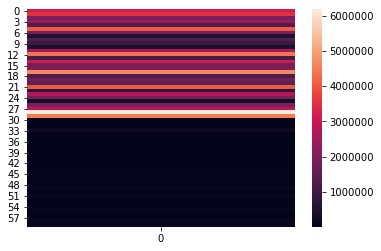

In [21]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(796717.5625, device='cuda:0')
tensor(4728.1104, device='cuda:0')


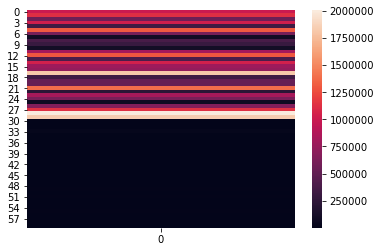

In [22]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(8928.6250, device='cuda:0')
tensor(2591.3750, device='cuda:0')


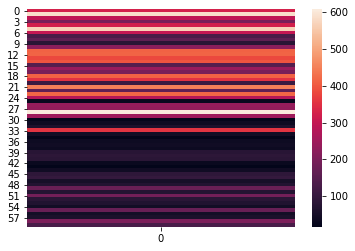

In [23]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2598.5815, device='cuda:0')
tensor(281.4185, device='cuda:0')


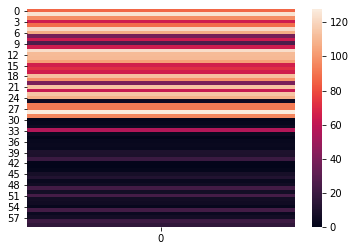

In [24]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[D:].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [25]:
(subset_indices_post_burnin[:(D)] > 0).sum()

tensor(30, device='cuda:0')

In [26]:
(subset_indices_post_burnin[(D):] > 0).sum()

tensor(30, device='cuda:0')

In [27]:
subset_indices_post_burnin[:(D)]

tensor([ 86.3519, 124.6065,  97.4129,  64.9263,  88.3379, 122.1557, 106.9105,
         38.7293,  63.3735,  25.5113,  64.4606, 123.0502, 111.6181, 111.0302,
        103.1693,  66.2841,  72.1795,  65.8081, 113.5081,  98.7405,  39.5107,
        113.9771,  62.7119, 114.2988, 107.8228,   5.1204,  91.8501,  91.8497,
        127.6550,  95.6204], device='cuda:0')

In [28]:
subset_indices_post_burnin[(D):]

tensor([8.5020e-01, 1.4964e+00, 4.3488e+00, 5.6197e+01, 3.5750e+00, 1.1299e-04,
        2.9735e+00, 3.3454e+00, 2.5383e+00, 1.0423e+01, 9.6293e+00, 1.9846e+01,
        6.4103e-01, 8.9528e-09, 1.9120e+00, 7.7096e+00, 1.1784e+01, 3.4404e+00,
        5.7468e+00, 2.2053e+01, 6.9491e+00, 2.2954e+01, 5.9961e+00, 5.1221e+00,
        2.4568e+00, 2.2644e+01, 3.9065e+00, 6.0480e+00, 2.0496e+01, 1.6335e+01],
       device='cuda:0')

In [29]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(2317.1631, device='cuda:0')

In [30]:
top_ind = torch.argsort(sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1), 
                        descending = True)[:vae_gumbel_truncated.k]

In [31]:
sum(top_ind < 30)

tensor(23, device='cuda:0')

In [32]:
sum(top_ind >= 30)

tensor(1, device='cuda:0')